In [1]:
import sys
import os

src_dir = os.path.dirname(os.getcwd())

if src_dir not in sys.path:
    sys.path.append(src_dir)
    
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
from utils import ddpm_schedules, CNN, DDPM, load_pickle
from plotting_utils import format_axes
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
from accelerate import Accelerator

# q1a_noise_schedule.png

Text(0, 0.5, '$\\beta_{t}$')

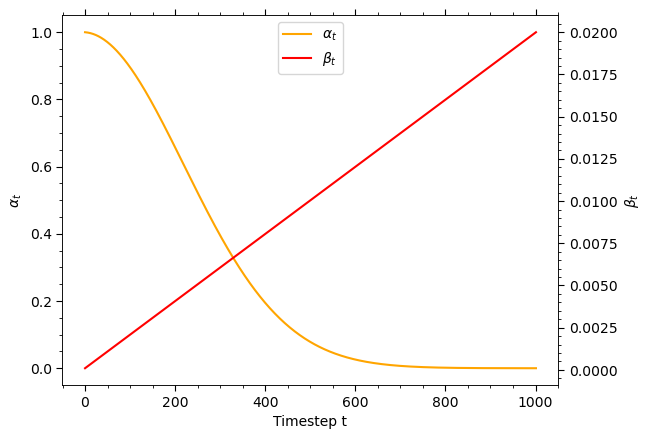

In [2]:
n_T = 1000

noise_schedule = ddpm_schedules(1e-4, 0.02, n_T)
alpha_t = noise_schedule['alpha_t']
beta_t = noise_schedule['beta_t']

x = np.linspace(0, 1001, 1001)

fig, ax = plt.subplots()
plt.plot(x, alpha_t, label=r'$\alpha_{t}$', c='orange')

ax2 = ax.twinx()
plt.plot(x, beta_t, label=r'$\beta_{t}$', c='red')

format_axes([ax, ax2], combine_legends=True, legend_loc='upper center')

ax.set_xlabel('Timestep t')
ax.set_ylabel(r'$\alpha_{t}$')
ax2.set_ylabel(r'$\beta_{t}$')

# plt.savefig(os.path.join(src_dir, f'../report/figures/q1a_noise_schedule.png'), bbox_inches='tight')

# q1a_image_noising.png

In [3]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = MNIST("../data", train=True, download=False, transform=tf)

In [4]:
torch.manual_seed(42)

mnist_noisy_images = torch.zeros(11 * 4, 1, 28, 28)

for sample in [0, 1, 2, 3]:
    x, label = dataset[sample]
    mnist_noisy_images[sample * 11] = x
    
    for idx, t in enumerate(range(100, 1001, 100)):
        eps = torch.randn_like(x)
        _alpha_t = alpha_t[t]
    
        z_t = torch.sqrt(_alpha_t) * x + torch.sqrt(1 - _alpha_t) * eps
        mnist_noisy_images[(idx + 1) + (sample * 11)] = z_t
    
grid = make_grid(mnist_noisy_images, nrow=11)
# save_image(grid, os.path.join(src_dir, f'../report/figures/q1a_image_noising.png'))

# q1a_image_reconstruction.png

In [11]:
torch.manual_seed(45)
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)
ddpm = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
state_dict = torch.load(f"{src_dir}/models/ddpm_mnist.pth")
ddpm.load_state_dict(state_dict)
ddpm = ddpm.to('mps')

In [12]:
samples_with_checkpoints = ddpm.sample(4, (1, 28, 28), device='mps', checkpoints=range(900, 0, -100))
samples_with_checkpoints = samples_with_checkpoints.to('cpu')

In [13]:
save_image(
    make_grid(samples_with_checkpoints.view([44, 1, 28, 28]), nrow=11),
    f'{src_dir}/../report/figures/q1a_image_reconstruction.png'
)

# q1b_noise_schedule.png

In [75]:
model1 = ddpm_schedules(1e-4, 0.02, 1000)
model2 = ddpm_schedules(1e-4, 0.1, 200)
model3 = ddpm_schedules(1e-4, 0.004, 5000)

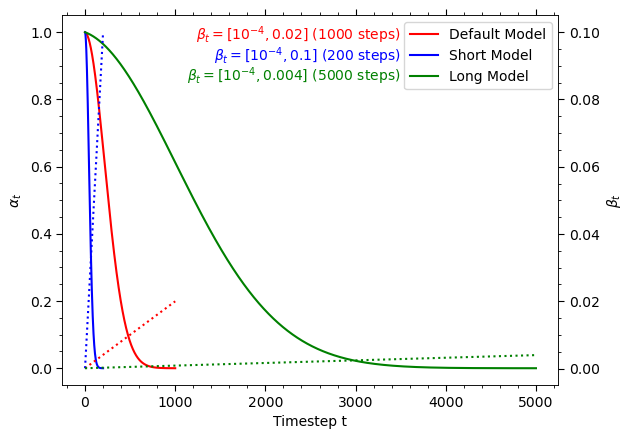

In [92]:
fig, ax = plt.subplots()
plt.plot(model1['alpha_t'], label=r'Default Model', c='red')
plt.plot(model2['alpha_t'], label=r'Short Model', c='blue')
plt.plot(model3['alpha_t'], label=r'Long Model', c='green')

ax2 = ax.twinx()
plt.plot(model1['beta_t'], label=r'$\beta_{t}$', c='red', linestyle=':')
plt.plot(model2['beta_t'], label=r'$\beta_{t}$', c='blue', linestyle=':')
plt.plot(model3['beta_t'], label=r'$\beta_{t}$', c='green', linestyle=':')

ax.legend()
format_axes([ax, ax2], legend_loc='upper center')

ax.set_xlabel('Timestep t')
ax.set_ylabel(r'$\alpha_{t}$')
ax2.set_ylabel(r'$\beta_{t}$')

ax.text(3500, 1.025, r'$\beta_{t} = [10^{-4}, 0.02]$ (1000 steps)', ha='right', va='top', 
         fontsize=10, color='red')
ax.text(3500, 0.9625, r'$\beta_{t} = [10^{-4}, 0.1]$ (200 steps)', ha='right', va='top', 
         fontsize=10, color='blue')
ax.text(3500, 0.9025, r'$\beta_{t} = [10^{-4}, 0.004]$ (5000 steps)', ha='right', va='top', 
         fontsize=10, color='green')

# plt.savefig(f'{src_dir}/../report/figures/q1b_noise_schedules.png', bbox_inches='tight')

# q1b_training_loss.png

In [39]:
losses_1 = load_pickle('../contents_1/ddpm_mnist_losses_0.pkl')
losses_2 = load_pickle('../contents_2/ddpm_mnist_losses_0.pkl')
losses_3 = load_pickle('../contents_3/ddpm_mnist_losses_0.pkl')

In [40]:
def calc_loss_per_epoch(losses, batches_per_epoch = 468):
    """Calculate the loss per epoch given the loss per batch"""
    
    loss_per_epoch = []
    n_epochs = int(len(losses_1) / 468)
    
    for i in range(n_epochs):
        start_idx = batches_per_epoch * i
        end_indx = start_idx + batches_per_epoch
        loss_per_epoch.append(np.mean(losses[start_idx:end_indx]))
    
    return loss_per_epoch
        
loss_epoch_1 = calc_loss_per_epoch(losses_1)
loss_epoch_2 = calc_loss_per_epoch(losses_2)
loss_epoch_3 = calc_loss_per_epoch(losses_3)

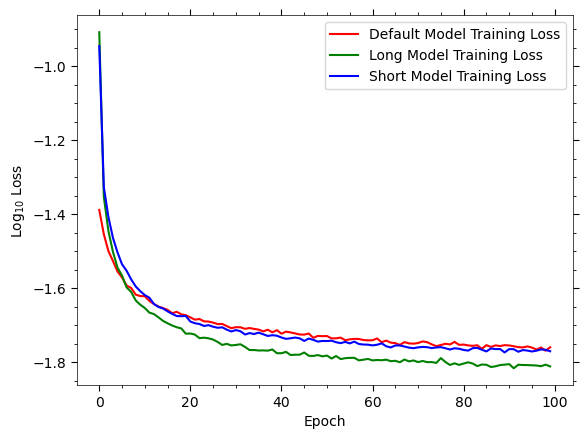

In [44]:
fig, ax = plt.subplots()

plt.plot(np.log10(loss_epoch_1), label='Default Model Training Loss', color='red')
plt.plot(np.log10(loss_epoch_3), label='Long Model Training Loss', color='green')
plt.plot(np.log10(loss_epoch_2), label='Short Model Training Loss', color='blue')
plt.legend()
plt.ylabel(r'Log$_{10}$ Loss')
plt.xlabel(r'Epoch')
format_axes(ax)

plt.savefig(f'{src_dir}/../report/figures/q1b_training_loss.png', bbox_inches='tight')

# q1b_short_model_nd.png + q1b_long_model_nd.png

In [5]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = MNIST("../data", train=True, download=False, transform=tf)

In [6]:
def generate_image_noising(num_samples, beta1, beta2, n_T, sample_ranges: range):
    torch.manual_seed(42)
    mnist_noisy_images = torch.zeros(11 * num_samples, 1, 28, 28)
    
    noise_schedule = ddpm_schedules(beta1, beta2, n_T)
    alpha_t = noise_schedule['alpha_t']
    beta_t = noise_schedule['beta_t']
    
    for sample in range(num_samples):
        x, label = dataset[sample]
        mnist_noisy_images[sample * 11] = x
        
        for idx, t in enumerate(sample_ranges):
            eps = torch.randn_like(x)
            _alpha_t = alpha_t[t]
        
            z_t = torch.sqrt(_alpha_t) * x + torch.sqrt(1 - _alpha_t) * eps
            mnist_noisy_images[(idx + 1) + (sample * 11)] = z_t
    
    return mnist_noisy_images

def generate_image_denoising(num_samples, beta1, beta2, n_T, sample_range: range, state_dict_filepath):
    gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)
    ddpm = DDPM(gt=gt, betas=(beta1, beta2), n_T=n_T)

    state_dict = torch.load(state_dict_filepath)
    ddpm.load_state_dict(state_dict)
    ddpm = ddpm.to('mps')
    
    samples_with_checkpoints = ddpm.sample(num_samples, (1, 28, 28), device='mps', checkpoints=sample_range)
    samples_with_checkpoints = samples_with_checkpoints.to('cpu')
    
    return samples_with_checkpoints

In [7]:
mnist_noisy_images_2 = generate_image_noising(2, 1e-4, 0.1, 200, range(20, 201, 20))
samples_with_checkpoints_2 = generate_image_denoising(2, 1e-4, 0.1, 200, range(180, 0, -20), f"{src_dir}/contents_2/ddpm_mnist_99.pth")

combined_2 = torch.cat([mnist_noisy_images_2, samples_with_checkpoints_2.view([22, 1, 28, 28])], dim=0)
grid_2 = make_grid(combined_2, nrow=11)
save_image(
    make_grid(grid_2, nrow=11),
    f'{src_dir}/../report/figures/q1b_short_model_nd.png'
)

In [9]:
mnist_noisy_images_3 = generate_image_noising(2, 1e-4, 0.004, 5000, range(500, 5001, 500))
samples_with_checkpoints_3 = generate_image_denoising(2, 1e-4, 0.004, 5000, range(4500, -0, -500), f"{src_dir}/contents_3/ddpm_mnist_99.pth")

combined_3 = torch.cat([mnist_noisy_images_3, samples_with_checkpoints_3.view([22, 1, 28, 28])], dim=0)
grid_3 = make_grid(combined_3, nrow=11)
save_image(
    make_grid(grid_3, nrow=11),
    f'{src_dir}/../report/figures/q1b_long_model_nd.png'
)

# q1b_fid.png

In [32]:
from torchvision.models import inception_v3, Inception_V3_Weights
from scipy.linalg import sqrtm
from torch.utils.data import DataLoader

In [29]:
inceptionv3 = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=False)
inceptionv3.fc = torch.nn.Identity()
inceptionv3.eval()

is_mps_avail = torch.backends.mps.is_available()

if is_mps_avail:
    inceptionv3 = inceptionv3.to('mps')

In [34]:
dataset = MNIST("../data", train=True, download=False, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)